In [ ]:
# Assignment3: song profiling
# Given the information collected in the previous assignment,
# build some song categories based on the lyrics or/and the melodic information available in the data.
# For this assignment, you can use any software/package you want!

In [1]:
import pandas as pd
import numpy as np
df_tracksClean = pd.read_csv('DataWithDateImputation.csv')
df_artistsClean = pd.read_csv('output2.csv')

In [ ]:
print("df_tracks:", df_tracksClean.columns)
print("df_artists:", df_artistsClean.columns)

In [ ]:
# Lyrical Features: swear_IT, swear_EN, n_sentences, n_tokens, char_per_tok
# Melodic/Acoustic Features: bpm,loudness,rms,rolloff,flux,flatnessspectral_complexity, pitch
# Metadata: year, popularity, duration_ms --> for cotext (possible dimensions)

In [2]:
#Rename for an easier merge later on
df_artistsClean.rename(columns={'id_author': 'id_artist'}, inplace=True)

In [3]:
from sklearn.preprocessing import StandardScaler

# Select Features
feature_cols = [
    'id', 'swear_IT', 'swear_EN', 'n_sentences', 'n_tokens', 'char_per_tok',
    'bpm', 'loudness', 'rms', 'rolloff', 'flux', 'flatness',
    'spectral_complexity', 'pitch', 'popularity', 'duration_ms', 'year'
]
df_features = df_tracksClean[feature_cols].copy()

# Identify features for scaling (numerical features that are not IDs/metadata)
scaling_features = [
    'swear_IT', 'swear_EN', 'n_sentences', 'n_tokens', 'char_per_tok',
    'bpm', 'loudness', 'rms', 'rolloff', 'flux', 'flatness',
    'spectral_complexity', 'pitch', 'popularity', 'duration_ms'
]


In [4]:
# 1.2. Handle Missing Data
# Fill 'year' NaNs (e.g., with median) before dropping other NaNs
if df_features['year'].isnull().any():
    df_features['year'].fillna(df_features['year'].median(), inplace=True)

# Drop rows with NaN values in the key scaling features
initial_rows = len(df_features)
df_features.dropna(subset=scaling_features, inplace=True)
print(f"Dropped {initial_rows - len(df_features)} rows due to missing key features.")

# Separate the data to be scaled
X = df_features[scaling_features]

Dropped 71 rows due to missing key features.


C:\Users\user\AppData\Local\Temp\ipykernel_62368\3733443420.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_features['year'].fillna(df_features['year'].median(), inplace=True)


In [5]:
# 1.3. Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=scaling_features, index=df_features.index)


--- 2. Clustering (K-Means) ---


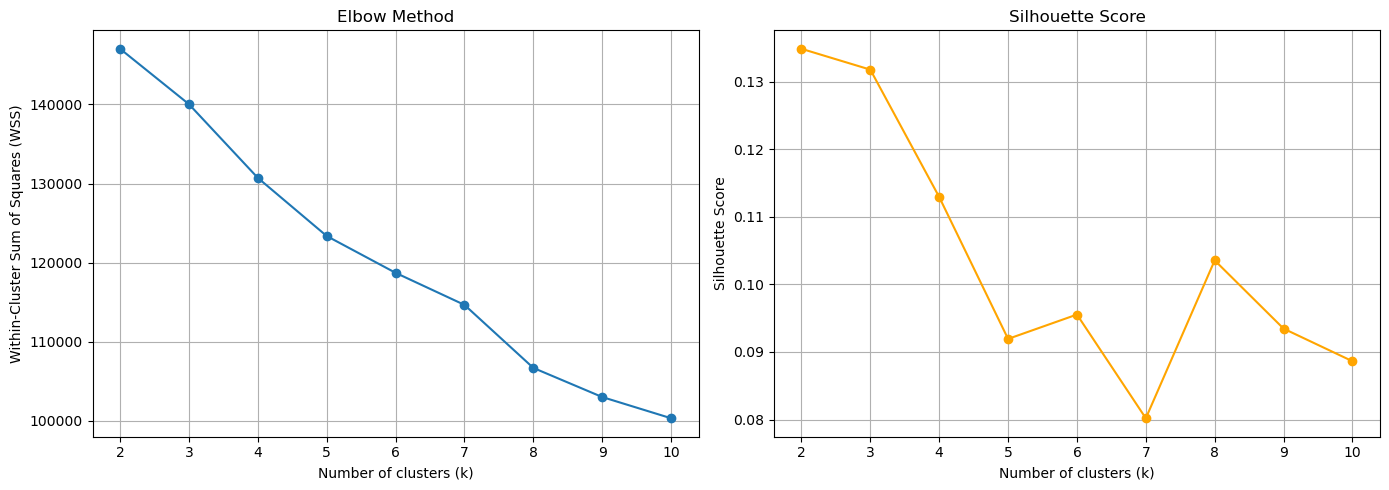

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

## --- 2. Unsupervised Clustering (K-Means) ---

print("\n--- 2. Clustering (K-Means) ---")

# 2.1. Determine Optimal Number of Clusters (Elbow Method)
# Calculate WCSS for a range of K values
wcss = []  # Within-Cluster Sum of Squares
sil_scores = []  # Silhouette Scores
k_range = range(2, 11)

for i in k_range:
    # Set n_init='auto' to silence warnings in newer scikit-learn versions
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled_df)
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled_df, labels))

# Plot WCSS and Silhouette Scores
plt.figure(figsize=(14,5))

# Elbow method
plt.subplot(1,2,1)
plt.plot(k_range, wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.grid(True)

# Silhouette Score
plt.subplot(1,2,2)
plt.plot(k_range, sil_scores, marker='o', color='orange')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


Optimal K selected: 3


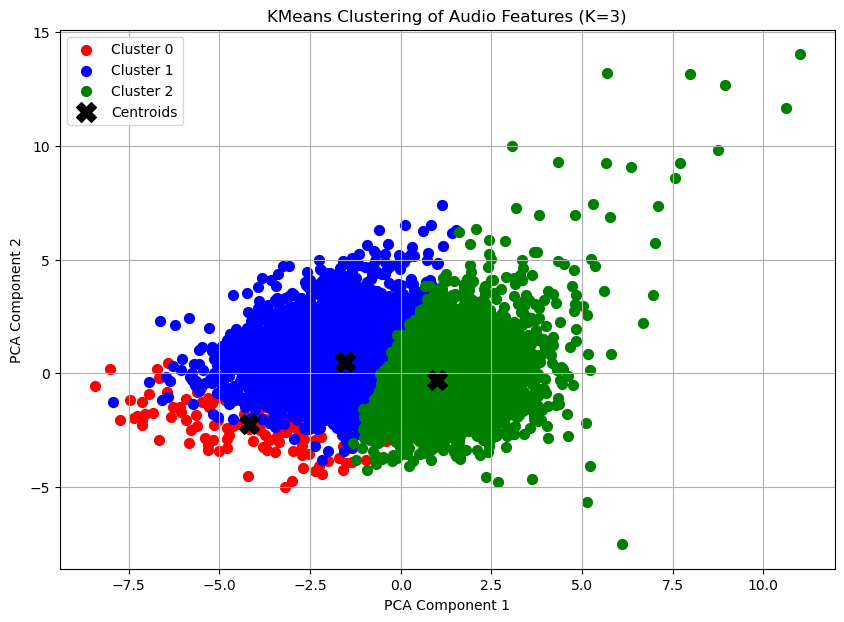

Cluster
0     118
1    4194
2    6780
Name: count, dtype: int64


In [12]:
from sklearn.decomposition import PCA

# 2.2. Perform K-Means Clustering
# Based on visual inspection of the Elbow plot, let's select K=5 as an example optimal point.
OPTIMAL_K = 3
print(f"\nOptimal K selected: {OPTIMAL_K}")

kmeans_final = KMeans(n_clusters=OPTIMAL_K, init='k-means++', random_state=42, n_init='auto')
clusters = kmeans_final.fit_predict(X_scaled_df)

# Add cluster labels back to the original (unscaled) feature dataframe
df_features['Cluster'] = clusters

#Visualization with pca
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)

plt.figure(figsize=(10,7))

colors = ['red', 'blue', 'green', 'orange']

for i in range(OPTIMAL_K):
    plt.scatter(
        X_pca[clusters == i, 0], 
        X_pca[clusters == i, 1],
        s=50,
        c=colors[i],
        label=f'Cluster {i}'
    )

# centroids transformed to PCA space
centroids_df = pd.DataFrame(kmeans_final.cluster_centers_, columns=X_scaled_df.columns)
centroids_pca = pca.transform(centroids_df)

plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    s=200,
    c='black',
    marker='X',
    label='Centroids'
)

plt.title(f"KMeans Clustering of Audio Features (K={OPTIMAL_K})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

print(df_features['Cluster'].value_counts().sort_index())

In [13]:
## --- 3. Profile and Categorize Clusters ---

print("\n--- 3. Cluster Profiling and Categorization ---")

# 3.1. Analyze Cluster Characteristics
# Calculate the mean of the original features for every cluster
cluster_profiles = df_features.groupby('Cluster')[scaling_features].mean().reset_index()

# Calculate the overall mean for comparison
overall_mean = df_features[scaling_features].mean()

print("\n--- Cluster Mean Profiles (Compared to Overall Mean) ---")
print("Overall Means:\n", overall_mean.round(2))
print("-" * 50)
print("Cluster Profiles:")
print(cluster_profiles.round(2))


--- 3. Cluster Profiling and Categorization ---

--- Cluster Mean Profiles (Compared to Overall Mean) ---
Overall Means:
 swear_IT                    2.35
swear_EN                    0.71
n_sentences                59.40
n_tokens                  496.68
char_per_tok                4.06
bpm                       114.14
loudness                   24.24
rms                         0.22
rolloff                  1617.22
flux                        1.26
flatness                    0.86
spectral_complexity        27.42
pitch                    2255.96
popularity                 32.55
duration_ms            203432.34
dtype: float64
--------------------------------------------------
Cluster Profiles:
   Cluster  swear_IT  swear_EN  n_sentences  n_tokens  char_per_tok     bpm  \
0        0      0.00      0.00         4.75     25.20          7.30  110.60   
1        1      1.68      0.42        51.42    426.08          4.04  113.63   
2        2      2.81      0.91        65.30    548.55        

In [ ]:
# Cluster 0: Very low values for swear_IT and swear_EN, 
# very few sentences and tokens. This cluster likely represents 
# short, clean tracks with minimal explicit content.

# Cluster 1: Values closer to the overall mean, slightly lower bpm
#  and moderate text length. This cluster likely represents 
# medium-length, moderately energetic tracks.

# Cluster 2: Higher values for n_tokens and n_sentences, 
# bpm slightly above average, and more audio complexity.
# This cluster likely represents longer, more energetic, and complex tracks.

Category_Name
Long Energetic Complex Tracks    6780
Medium-Length Moderate Energy    4194
Clean Short Tracks                118
Name: count, dtype: int64


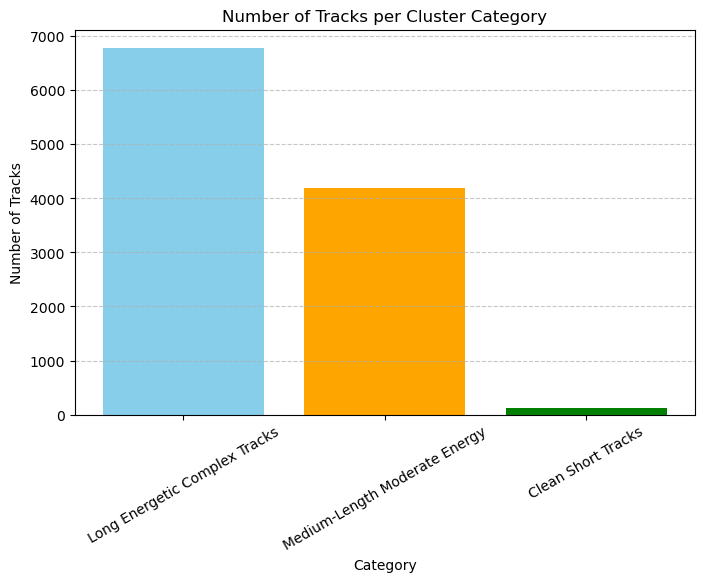

In [21]:
# 3.2. Naming and Categorization (Manual Interpretation)
CLUSTER_NAMES = {
    0: "Clean Short Tracks",
    1: "Medium-Length Moderate Energy",
    2: "Long Energetic Complex Tracks"
}
df_features['Category_Name'] = df_features['Cluster'].map(CLUSTER_NAMES)

print(df_features['Category_Name'].value_counts())

# Count of tracks per category
category_counts = df_features['Category_Name'].value_counts()

# Matplotlib version
plt.figure(figsize=(8,5))
plt.bar(category_counts.index, category_counts.values, color=['skyblue', 'orange', 'green'])
plt.title("Number of Tracks per Cluster Category")
plt.ylabel("Number of Tracks")
plt.xlabel("Category")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [26]:
df_features.columns

Index(['id', 'swear_IT', 'swear_EN', 'n_sentences', 'n_tokens', 'char_per_tok',
       'bpm', 'loudness', 'rms', 'rolloff', 'flux', 'flatness',
       'spectral_complexity', 'pitch', 'popularity', 'duration_ms', 'year',
       'Cluster', 'Category_Name'],
      dtype='object')

In [ ]:
#  Made a mistake and removed it from df_feature so now ill add it back
artist_id_map = df_tracksClean[['id', 'id_artist']].set_index('id')

#I use 'id' to merge back the 'id_artist' into df_features
df_features = df_features.merge(
    artist_id_map.reset_index(),
    on='id',
    how='left'
)

# Verify that 'id_artist' has been added back
if 'id_artist' in df_features.columns:
    print("SUCCESS: 'id_artist' è stata aggiunta a df_features.")
else:
    print("ERROR: La colonna 'id_artist' non è stata aggiunta correttamente.")

SUCCESS: 'id_artist' è stata aggiunta a df_features.


In [28]:
## --- 4. Integration with Artist Data (Enhancement) ---

print("\n--- 4. Artist Profile Integration ---")

# 4.1. Merge Cluster Data with Artist Metadata
# Merge clustered tracks with artist gender/nationality data
df_full_data = df_features[['id', 'id_artist', 'Cluster', 'Category_Name']].merge(
    df_artistsClean[['id_artist', 'gender', 'nationality']],
    on='id_artist',
    how='left'
)


--- 4. Artist Profile Integration ---


In [29]:
# 4.2. Analyze Dominant Artist Characteristics per Category

print("\nDominant Gender Distribution per Category:")
gender_analysis = df_full_data.groupby('Category_Name')['gender'].value_counts(normalize=True).mul(100).unstack(fill_value=0)
print(gender_analysis.sort_values(by=gender_analysis.columns[0], ascending=False).head())

print("\nTop 3 Nationalities per Category:")
for name, group in df_full_data.groupby('Category_Name'):
    top_nationalities = group['nationality'].value_counts(normalize=True).mul(100).head(3)
    print(f"\nCategory: {name}")
    print(top_nationalities.round(1).to_string())

# Final dataframe containing all features and the assigned category
df_song_profiles = df_features.merge(df_full_data[['id', 'gender', 'nationality']], on='id', how='left')
print("\nFinal Song Profiles created successfully (df_song_profiles).")


Dominant Gender Distribution per Category:
gender                                F          M
Category_Name                                     
Medium-Length Moderate Energy  6.009390  93.990610
Long Energetic Complex Tracks  4.982517  95.017483
Clean Short Tracks             3.361345  96.638655

Top 3 Nationalities per Category:

Category: Clean Short Tracks
nationality
Italia       71.9
Argentina    28.1

Category: Long Energetic Complex Tracks
nationality
Italia       99.8
Argentina     0.2

Category: Medium-Length Moderate Energy
nationality
Italia       99.8
Argentina     0.2

Final Song Profiles created successfully (df_song_profiles).


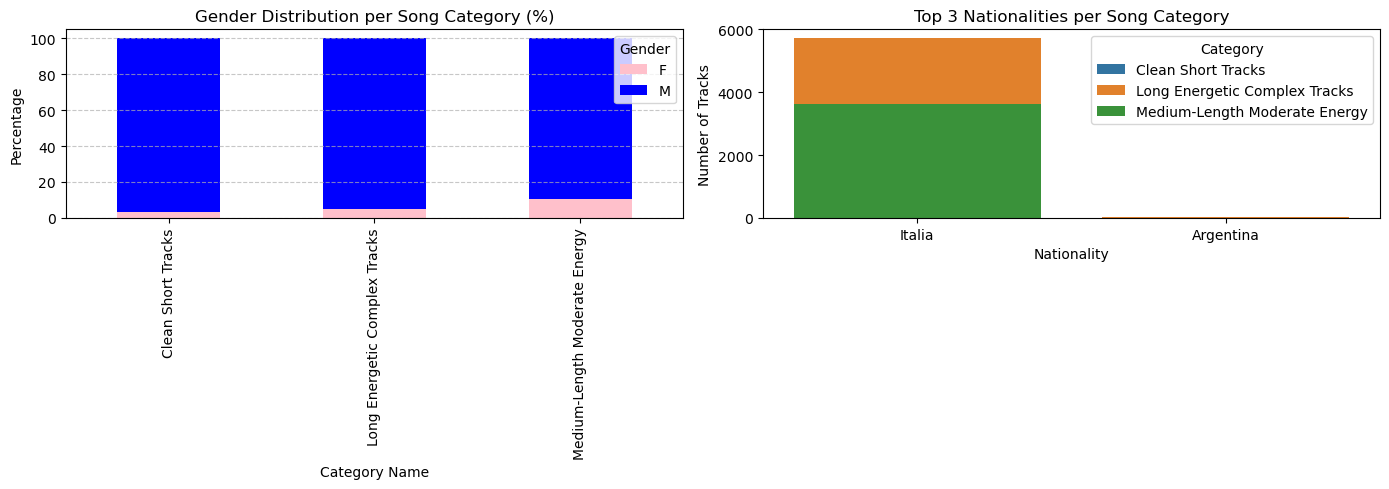

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare gender data
gender_analysis = df_song_profiles.groupby('Category_Name')['gender'].value_counts(normalize=True).mul(100).unstack(fill_value=0)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# 1️⃣ Gender Distribution (Stacked Bar)
gender_analysis.plot(
    kind='bar',
    stacked=True,
    color={'M': 'blue', 'F': 'pink'},
    ax=axes[0]
)
axes[0].set_title("Gender Distribution per Song Category (%)")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Category Name")
axes[0].legend(title="Gender")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 2️⃣ Top 3 Nationalities per Category
for name, group in df_song_profiles.groupby('Category_Name'):
    top_nationalities = group['nationality'].value_counts().head(3)
    sns.barplot(
        x=top_nationalities.index,
        y=top_nationalities.values,
        label=name,
        ax=axes[1]
    )
axes[1].set_title("Top 3 Nationalities per Song Category")
axes[1].set_ylabel("Number of Tracks")
axes[1].set_xlabel("Nationality")
axes[1].legend(title="Category")

plt.tight_layout()
plt.show()


In [35]:
#OPTION 2:
import nltk

# 1. Download Stopwords (Fixes LookupError)
nltk.download('stopwords')

# 2. Download Wordnet (Needed for Lemmatization)
nltk.download('wordnet')

# 3. Download Punkt (Needed for Tokenization/General Text Processing)
nltk.download('punkt')

print("NLTK Resources (stopwords, wordnet, punkt) downloaded successfully.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


NLTK Resources (stopwords, wordnet, punkt) downloaded successfully.


In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure necessary NLTK data is downloaded (run once)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')

# --- Load Data (Placeholder: assuming data is already loaded) ---
df_tracks = pd.read_csv('TracksAlmostClean.csv')
df_artists = pd.read_csv('output2.csv')

# Use a deep copy for processing to keep the original DataFrame intact
df_profiling = df_tracks.copy()

# --- 1. Acoustic Data Preparation ---
ACOUSTIC_FEATURES = [
    'bpm', 'rms', 'rolloff', 'flux', 'flatness',
    'spectral_complexity', 'pitch', 'duration_ms'
]

# Drop rows with NaNs in acoustic features
initial_rows = len(df_profiling)
df_profiling.dropna(subset=ACOUSTIC_FEATURES, inplace=True)
print(f"Acoustic profiling data prepared. {initial_rows - len(df_profiling)} rows dropped due to NaN in acoustic features.")

# Scale the acoustic features
scaler_acoustic = StandardScaler()
X_acoustic = df_profiling[ACOUSTIC_FEATURES]
X_scaled_acoustic = scaler_acoustic.fit_transform(X_acoustic)

Acoustic profiling data prepared. 0 rows dropped due to NaN in acoustic features.



--- Starting Hierarchical Clustering for Acoustic Features ---


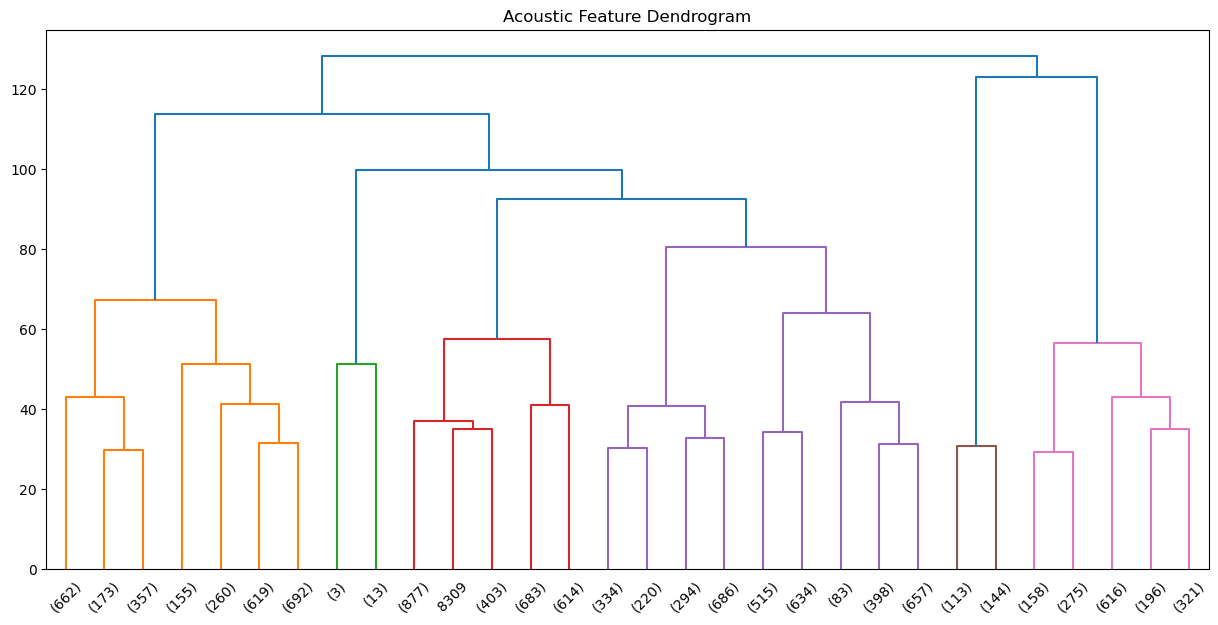

In [39]:
# --- 2. Hierarchical Clustering ---
print("\n--- Starting Hierarchical Clustering for Acoustic Features ---")

# 2.1. Perform Linkage (Ward's method is common for Euclidean distance)
Z = linkage(X_scaled_acoustic, method='ward', metric='euclidean')

# Note: In a full project, you would plot the dendrogram here
# to visually determine the optimal number of clusters (K).
plt.figure(figsize=(15, 7))
dendrogram(
    Z,
    truncate_mode='lastp',  # Truncate the display
    p=30,                   # Show only the last 30 merged clusters (the top of the tree)
    show_leaf_counts=True   # Show how many original points are in each leaf
)
plt.title('Acoustic Feature Dendrogram')
plt.show()

In [ ]:

# 2.2. Cut the Dendrogram (Example K=5 chosen visually)
K_ACOUSTIC = 5
acoustic_clusters = fcluster(Z, K_ACOUSTIC, criterion='maxclust')
df_profiling['Acoustic_Cluster'] = acoustic_clusters.astype(str)

print(f"Hierarchical Clustering complete. Found {K_ACOUSTIC} Acoustic Clusters.")
print(df_profiling['Acoustic_Cluster'].value_counts())

Hierarchical Clustering complete. Found 5 Acoustic Clusters.
Acoustic_Cluster
3    6399
1    2918
5    1566
4     257
2      16
Name: count, dtype: int64


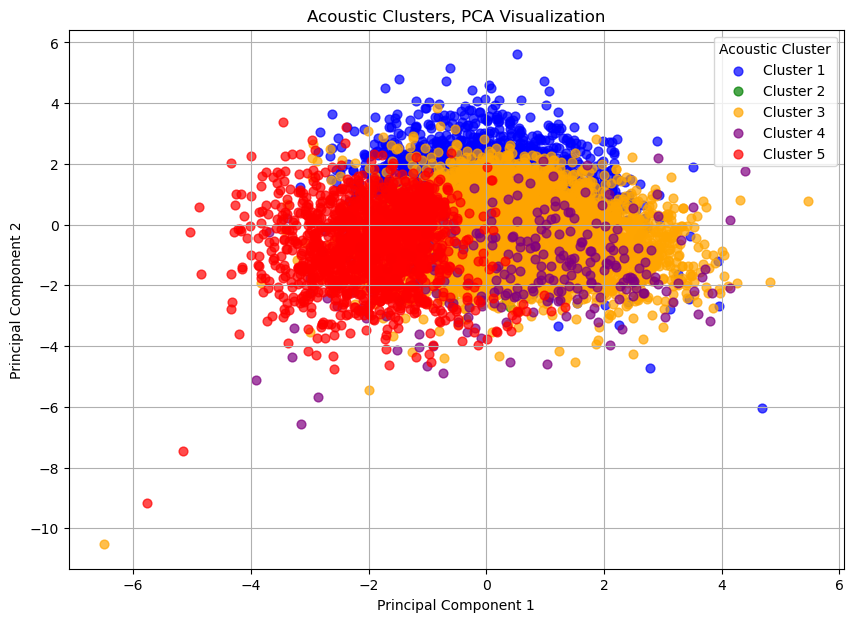

In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Apply PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_acoustic)

df_profiling['PC1'] = X_pca[:, 0]
df_profiling['PC2'] = X_pca[:, 1]

# 2. Plot
plt.figure(figsize=(10,7))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for c in sorted(df_profiling['Acoustic_Cluster'].unique()):
    cluster_data = df_profiling[df_profiling['Acoustic_Cluster'] == c]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'],
                label=f"Cluster {c}", s=40, alpha=0.7,
                color=colors[int(c) % len(colors)])

plt.title("Acoustic Clusters, PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Acoustic Cluster")
plt.grid(True)
plt.show()


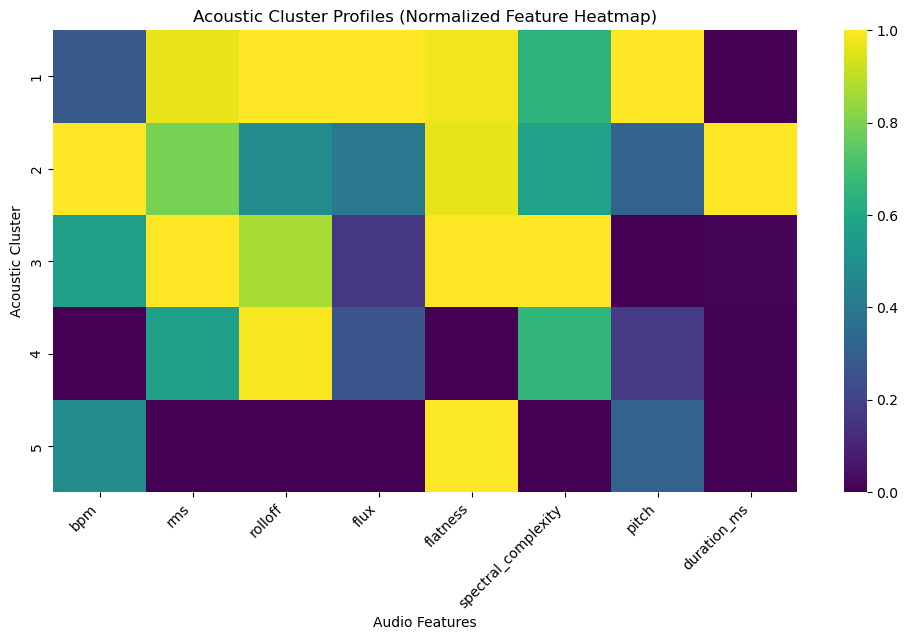

In [43]:
import seaborn as sns

# Compute cluster means
acoustic_means = df_profiling.groupby('Acoustic_Cluster')[ACOUSTIC_FEATURES].mean()

# Normalize values (optional but makes visualization cleaner)
acoustic_means_norm = (acoustic_means - acoustic_means.min()) / (acoustic_means.max() - acoustic_means.min())

plt.figure(figsize=(12,6))
sns.heatmap(acoustic_means_norm, annot=False, cmap='viridis')
plt.title("Acoustic Cluster Profiles (Normalized Feature Heatmap)")
plt.ylabel("Acoustic Cluster")
plt.xlabel("Audio Features")
plt.xticks(rotation=45, ha='right')
plt.show()


In [44]:
#Lyircal profiling:
# --- 3. Lyrical Data Preparation and Preprocessing ---
print("\n--- Starting Lyrical Topic Modeling (LDA) ---")

# Drop songs where lyrics are missing or empty
df_profiling.dropna(subset=['lyrics'], inplace=True)
df_profiling = df_profiling[df_profiling['lyrics'].str.strip() != '']

# Define a comprehensive list of stopwords (English and Italian)
stop_words = set(stopwords.words('english') + stopwords.words('italian'))
lemmatizer = nltk.WordNetLemmatizer()

def preprocess_lyrics(text):
    text = str(text).lower()
    # Remove punctuation, numbers, and extra spaces
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

# Apply preprocessing (using tqdm for progress bar)
tqdm.pandas(desc="Preprocessing Lyrics")
df_profiling['lyrics_processed'] = df_profiling['lyrics'].progress_apply(preprocess_lyrics)


--- Starting Lyrical Topic Modeling (LDA) ---


Preprocessing Lyrics: 100%|██████████| 11156/11156 [00:45<00:00, 247.51it/s]


In [46]:
# --- 4. Topic Modeling (LDA) ---
# 4.1. Vectorization (Using CountVectorizer)
vectorizer = CountVectorizer(
    max_df=0.85, # Ignore terms that appear in more than 85% of documents
    min_df=5,    # Ignore terms that appear in less than 5 documents
    stop_words=None # Stopwords already removed in preprocessing
)
data_vectorized = vectorizer.fit_transform(df_profiling['lyrics_processed'])

# 4.2. LDA Model Fitting
N_TOPICS = 8 # Example number of topics (determined by coherence score analysis)

lda_model = LatentDirichletAllocation(
    n_components=N_TOPICS,
    max_iter=5,
    learning_method='online',
    random_state=42
)
lda_output = lda_model.fit_transform(data_vectorized)

# 4.3. Feature Creation and Naming
topic_names = [f'Topic_{i}_Score' for i in range(N_TOPICS)]
df_topics = pd.DataFrame(lda_output, columns=topic_names, index=df_profiling.index)
df_profiling = pd.concat([df_profiling, df_topics], axis=1)

# Assign the dominant topic as the Lyrical Cluster
df_profiling['Lyrical_Cluster'] = np.argmax(lda_output, axis=1).astype(str)

print(f"LDA Topic Modeling complete. Found {N_TOPICS} Lyrical Topics (Clusters).")

LDA Topic Modeling complete. Found 8 Lyrical Topics (Clusters).


In [47]:
import numpy as np
# Assuming 'lda_model' and 'vectorizer' are defined from your previous run.

def print_top_words(model, feature_names, n_top_words):
    """
    Analyzes the LDA model components to print the top weighted words for each topic.
    """
    print(f"\n--- Top {n_top_words} Words for All {model.n_components} Topics ---")
    
    # Iterate through each topic
    for topic_idx, topic in enumerate(model.components_):
        # Sort words by weight and select the top N
        top_words_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_indices]
        
        # Print the topic index and its dominant words
        print(f"Topic {topic_idx}: {', '.join(top_words)}")

# --- Execution ---
N_TOP_WORDS = 10 
feature_names = vectorizer.get_feature_names_out()

print_top_words(lda_model, feature_names, N_TOP_WORDS)


--- Top 10 Words for All 8 Topics ---
Topic 0: dont, crack, get, like, one, fuck, man, back, shit, mic
Topic 1: co, vai, piace, senza, badabum, poi, quando, bene, fare, parole
Topic 2: mai, musica, peso, ogni, dentro, senza, tempo, qui, vita, nero
Topic 3: nun, que, love, cchi, pecch, int, tutte, comme, tengo, sulo
Topic 4: yeah, ehi, fra, soldi, seh, gang, ahah, baby, fare, uoh
Topic 5: cazzo, rap, quando, perch, gente, merda, fra, fare, tipo, poi
Topic 6: hop, top, know, let, bum, rap, new, show, hip, make
Topic 7: solo, perch, quando, sempre, mai, poi, vita, cosa, ancora, sai



Lyrical Categories have been assigned to songs.

Distribution of Lyrical Categories:
Lyrical_Category_Name
Contemplative/Existential Italian      5774
Explicit/Rebellious Italian Rap        2209
Trap/Street Culture (Italian)          1789
Neapolitan/Southern Italian Love        412
Generic Italian Pop/Dialogue            326
Explicit/Aggressive English Rap         238
Introspective/Deep Italian              217
Classic Hip-Hop/Performance English     191
Name: count, dtype: int64

--- Visualizing Lyrical Category Distribution ---


C:\Users\user\AppData\Local\Temp\ipykernel_62368\2372443794.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


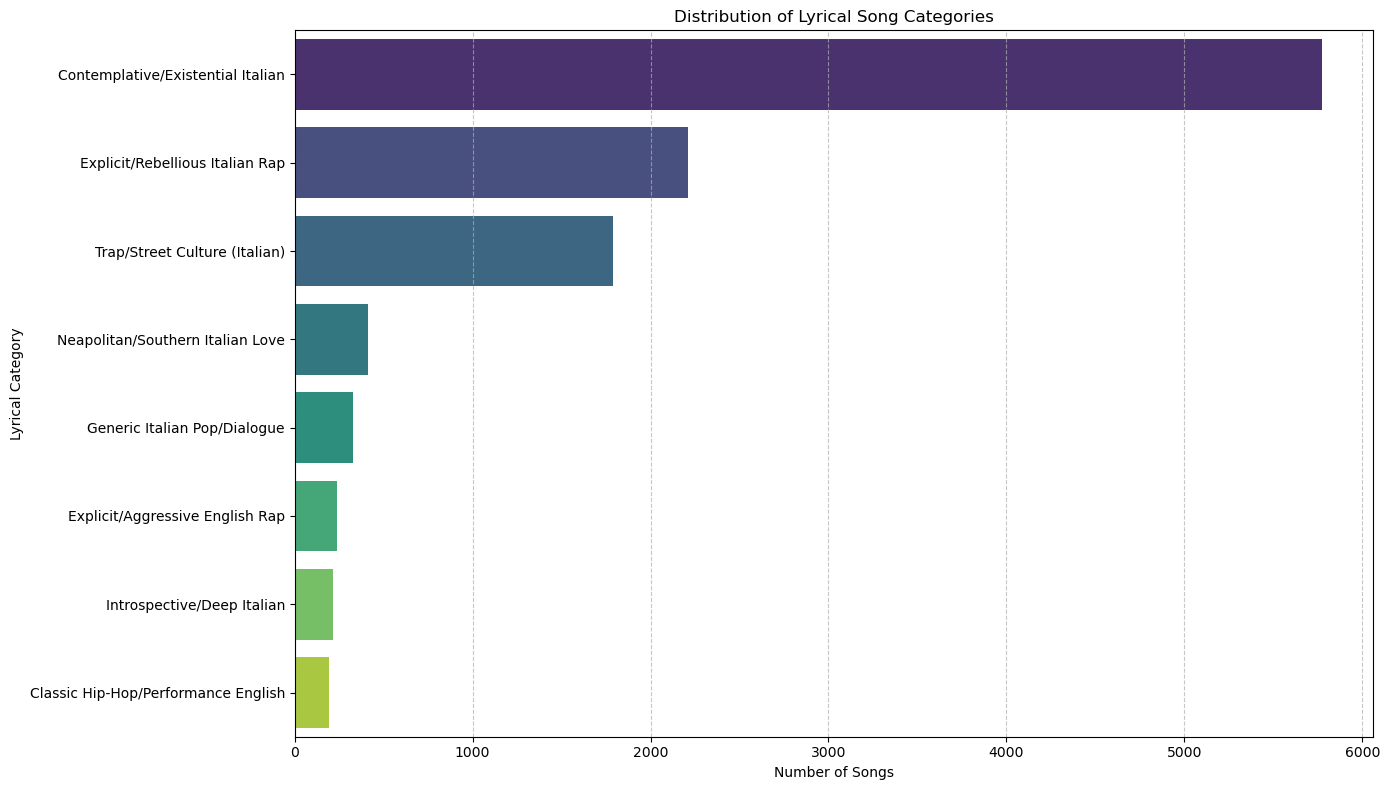

In [48]:
# --- Define the Lyrical Category Names based on the interpretation ---
LYRICAL_CATEGORY_NAMES = {
    '0': 'Explicit/Aggressive English Rap',
    '1': 'Generic Italian Pop/Dialogue',
    '2': 'Introspective/Deep Italian',
    '3': 'Neapolitan/Southern Italian Love',
    '4': 'Trap/Street Culture (Italian)',
    '5': 'Explicit/Rebellious Italian Rap',
    '6': 'Classic Hip-Hop/Performance English',
    '7': 'Contemplative/Existential Italian',
}

# Apply the mapping to create the new categorical column
df_profiling['Lyrical_Category_Name'] = df_profiling['Lyrical_Cluster'].map(LYRICAL_CATEGORY_NAMES)

print("\nLyrical Categories have been assigned to songs.")
print("\nDistribution of Lyrical Categories:")
print(df_profiling['Lyrical_Category_Name'].value_counts())

# --- Visualization of Lyrical Category Distribution ---
print("\n--- Visualizing Lyrical Category Distribution ---")

plt.figure(figsize=(14, 8))
sns.countplot(
    data=df_profiling,
    y='Lyrical_Category_Name', # Use 'y' for horizontal bars to make labels readable
    order=df_profiling['Lyrical_Category_Name'].value_counts().index, # Order by frequency
    palette='viridis'
)
plt.title('Distribution of Lyrical Song Categories')
plt.xlabel('Number of Songs')
plt.ylabel('Lyrical Category')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

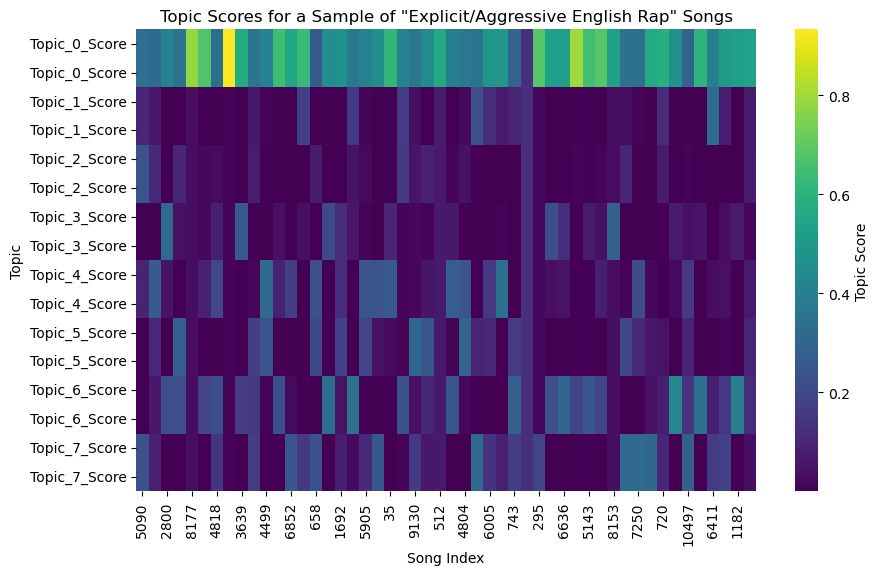

In [49]:
# You can also visualize the topic scores for a sample of songs within each category
# For example, to see topic score distribution for 'Explicit/Aggressive English Rap'
sample_category_data = df_profiling[df_profiling['Lyrical_Category_Name'] == 'Explicit/Aggressive English Rap'][topic_names].sample(min(50, len(df_profiling)))
plt.figure(figsize=(10, 6))
sns.heatmap(sample_category_data.T, cmap='viridis', cbar_kws={'label': 'Topic Score'})
plt.title('Topic Scores for a Sample of "Explicit/Aggressive English Rap" Songs')
plt.ylabel('Topic')
plt.xlabel('Song Index')
plt.show()

In [50]:
#OPTION 3:
# --- 5. Combination and Final Clustering ---
print("\n--- Starting Combined K-Means Clustering ---")

# 5.1. Prepare Combined Features

# 1. Acoustic Dummies (The derived H-Clustering groups)
acoustic_dummies = pd.get_dummies(df_profiling['Acoustic_Cluster'], prefix='Acoustic_C')

# 2. Lyrical Topic Scores (LDA probabilities)
lyrical_topics = df_profiling[topic_names]

# Combine the two feature sets
X_combined = pd.concat([acoustic_dummies, lyrical_topics], axis=1)

# 5.2. Perform Final K-Means Clustering
# Using K=5 as an example for the final categories
K_FINAL = 5

kmeans_final = KMeans(n_clusters=K_FINAL, init='k-means++', random_state=42, n_init='auto')
final_clusters = kmeans_final.fit_predict(X_combined)
df_profiling['Final_Song_Category'] = final_clusters.astype(str)

# --- 6. Profiling the Final Categories ---
print(f"Combined K-Means Clustering complete. Found {K_FINAL} Final Song Categories.")
print("\n--- Final Category Profiles (Acoustic and Lyrical Dominance) ---")

# Combine the original acoustic features with the combined features for profiling
acoustic_profile_cols = ACOUSTIC_FEATURES + topic_names + ['Final_Song_Category']
final_profiles = df_profiling[acoustic_profile_cols].groupby('Final_Song_Category').mean()

print(final_profiles.round(3))

# --- Interpretation Example (Must be manual based on the final_profiles table) ---
# Category 0: High BPM, High Loudness, High Topic_2_Score (e.g., Party/Dance)
# Category 1: Low BPM, Low Loudness, High Topic_5_Score (e.g., Melancholy Ballads)
# ...

# You should now manually analyze final_profiles to assign meaningful names:
# e.g., Category 0 -> "High-Energy Dance Floor Hits"

print("\nProfiling successful. The 'Final_Song_Category' column contains the comprehensive song profiles.")


--- Starting Combined K-Means Clustering ---
Combined K-Means Clustering complete. Found 5 Final Song Categories.

--- Final Category Profiles (Acoustic and Lyrical Dominance) ---
                         bpm    rms   rolloff   flux  flatness  \
Final_Song_Category                                              
0                    109.162  0.195  1686.861  1.239     0.272   
1                    114.205  0.236  1566.736  1.190     0.886   
2                    112.021  0.237  1684.385  1.392     0.866   
3                    114.298  0.135  1373.017  1.185     0.874   
4                    116.100  0.246  1712.826  1.243     0.871   

                     spectral_complexity     pitch  duration_ms  \
Final_Song_Category                                               
0                                 25.906  2195.971   218737.011   
1                                 30.230  2095.807   209021.452   
2                                 25.703  2532.450   191798.140   
3                    

In [53]:
#  WARNING: YOU MUST UPDATE THE CATEGORY NAMES BELOW BASED ON YOUR FULL ANALYSIS ⚠️
FINAL_CATEGORY_MAPPING = {
    '0': 'Mid-Tempo Aggressive Rap',
    '1': 'High-Energy Italian Pop',
    '2': 'Contemplative Street Rap',
    '3': 'Minimalist Acoustic Ballads',
    '4': 'High-Fidelity Complex Hip-Hop',
}

# Apply the mapping to the final cluster labels
df_profiling['Final_Category_Name'] = df_profiling['Final_Song_Category'].map(FINAL_CATEGORY_MAPPING)

print("\nFinal Categorization Complete.")
print("Distribution of the 5 Final Song Categories:")
print(df_profiling['Final_Category_Name'].value_counts())

# Save the final DataFrame containing all profiles and the new category name
df_profiling.to_csv('df_final_profiles_with_names.csv', index=False)


Final Categorization Complete.
Distribution of the 5 Final Song Categories:
Final_Category_Name
High-Fidelity Complex Hip-Hop    3338
High-Energy Italian Pop          3070
Contemplative Street Rap         2920
Minimalist Acoustic Ballads      1567
Mid-Tempo Aggressive Rap          261
Name: count, dtype: int64


In [ ]:
###################################################

In [20]:
# Assumendo che 'swear_IT_words' e 'swear_EN_words' siano il conteggio totale di parolacce.
# Calcoliamo la densità di parolacce (per token totali, se hai 'n_tokens')
df_tracks['total_swears'] = df_tracks['swear_IT_words'] + df_tracks['swear_EN_words']

# Creazione di categorie logiche di contenuto (Imputazione concettuale per 'lyric_category'):
def classify_lyric_content(row):
    if row['total_swears'] > 15:
        return 'Contenuto Esplicito Forte'
    elif row['total_swears'] > 3:
        return 'Contenuto Leggermente Esplicito'
    else:
        return 'Contenuto Pulito'

df_tracks['lyric_category_swears'] = df_tracks.apply(classify_lyric_content, axis=1)

print("\nCategorizzazione basata sull'uso di parolacce:")
print(df_tracks['lyric_category_swears'].value_counts())


Categorizzazione basata sull'uso di parolacce:
lyric_category_swears
Contenuto Pulito    11166
Name: count, dtype: int64


In [18]:
# 1. Combinazione delle Categorie
df_tracks['song_profile_ID'] = df_tracks['audio_cluster'].astype(str) + '-' + df_tracks['lyric_category_swears']

print("\nProfili Complessivi:")
print(df_tracks['song_profile_ID'].value_counts())

# 2. Interpretazione dei Profili (Esempio)
# Analizziamo un profilo specifico (es. Cluster Audio 3 e Contenuto Esplicito Forte)
profile_3_strong = df_tracks[df_tracks['song_profile_ID'] == '3-Contenuto Esplicito Forte']

# Calcolo delle medie delle feature per questo profilo
mean_features = profile_3_strong[audio_features].mean()

# Esempio di Interpretazione:
print("\n--- Analisi del Profilo '3-Contenuto Esplicito Forte' ---")
print(f"Numero di brani in questo profilo: {len(profile_3_strong)}")
print(f"BPM Medio: {mean_features['bpm']:.1f}")
# Se il BPM è alto e il contenuto è esplicito, potremmo nominare il profilo:
# "Hip-Hop / Dance Energetica dal Contenuto Forte"

print("\n--- Categorie Finali Suggerite ---")
# 0-Contenuto Pulito: 'Pop Lento Acustico (Clean)'
# 3-Contenuto Esplicito Forte: 'Brano Rap/Dance Energetico (Explicit)'
# 1-Contenuto Pulito: 'Rock Classico (Pulito)'

# La definizione finale dei profili è un esercizio di business intelligence/interpretazione.


Profili Complessivi:
song_profile_ID
3.0-Contenuto Pulito    4007
1.0-Contenuto Pulito    3964
2.0-Contenuto Pulito    2857
0.0-Contenuto Pulito     274
nan-Contenuto Pulito      64
Name: count, dtype: int64

--- Analisi del Profilo '3-Contenuto Esplicito Forte' ---
Numero di brani in questo profilo: 0
BPM Medio: nan

--- Categorie Finali Suggerite ---
